# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

### Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 40
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                      
                                        download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [6]:
# Define the loss function
MAE=nn.L1Loss()#L1 loss
crossentropy = nn.CrossEntropyLoss()#crossentropy

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, pred, target):
        crossentropy = nn.CrossEntropyLoss()
        cross=crossentropy(pred,target)
        loss=(1-torch.exp(-cross))** self.gamma * cross
        return torch.mean(loss)

In [8]:
FocalLoss1=FocalLoss(0.5)#gamma=0.5
FocalLoss2=FocalLoss(2)#gamma=2

In [9]:
def train_batch(model, image, target,lfunc):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    output = model(image)
    if lfunc==1:                                              #MAE
        output_softmax = nn.functional.softmax(output, dim=1)
        target_onehot=torch.nn.functional.one_hot(target,10)
        loss=MAE(output_softmax,target_onehot)
    elif lfunc==2:                                            #CrossEntropy
        loss=crossentropy(output,target)
    elif lfunc==3:                                            #FocalLoss,gamma=0.5
        loss=FocalLoss1(output,target)
    else:                                                     #FocalLoss,gamma=2
        loss=FocalLoss2(output,target)

    return output, loss

In [10]:
def test_batch(model, image, target,lfunc):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    output = model(image)
    if lfunc==1:                                              #MAE
        output_softmax = nn.functional.softmax(output, dim=1)
        target_onehot=torch.nn.functional.one_hot(target,10)
        loss=MAE(output_softmax,target_onehot)
    elif lfunc==2:                                            #CrossEntropy
        loss=crossentropy(output,target)
    elif lfunc==3:                                            #FocalLoss,gamma=0.5
        loss=FocalLoss1(output,target)
    else:                                                     #FocalLoss,gamma=2
        loss=FocalLoss2(output,target)

    return output, loss

### Model Training

### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [11]:
def test(model,optimizer,scheduler,lfunc):
    training_loss = []
    training_acc = []
    testing_loss = []
    testing_acc = []
    torch.cuda.synchronize()
    start = time.time()
    

    for epoch in range(NUM_EPOCHS):

    ##########################
    ### Training
    ##########################

        running_cls_loss = 0.0
        running_cls_corrects = 0

        for batch_idx, (image, target) in enumerate(train_dataloader):

            image = image.to(device)
            target = target.to(device)

            # train model
            outputs, loss = train_batch(model, image, target,lfunc)
            _, preds = torch.max(outputs, 1)

        
            loss_data = loss.data.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
            running_cls_loss += loss.item()
            running_cls_corrects += torch.sum(preds == target.data)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss = running_cls_loss*BATCH_SIZE / len(train_set)
        epoch_acc = running_cls_corrects.double() / len(train_set)

        print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        training_loss.append(epoch_loss)
        training_acc.append(epoch_acc.cpu().detach().numpy())

        
        scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
        if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
            print('Begin test......')
            model.eval()
    
            val_loss = 0.0
            val_corrects = 0

            for batch_idx, (image, target) in enumerate(test_dataloader):

                image = image.to(device)
                target = target.to(device)

            # test model
                outputs, loss = test_batch(model, image, target,lfunc)
                _, preds = torch.max(outputs, 1)
            
                val_loss += loss.item()
                val_corrects += torch.sum(preds == target.data)

            val_loss = val_loss*BATCH_SIZE / len(test_set)
            val_acc = val_corrects.double() / len(test_set)
            print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
            testing_loss.append(val_loss)
            testing_acc.append(val_acc.cpu().detach().numpy())
 
            # save the model in last epoch
            if (epoch +1) == NUM_EPOCHS:
                
                state = {
                'state_dict': model.state_dict(),
                'acc': epoch_acc,
                'epoch': (epoch+1),
                }

                # check the dir
                if not os.path.exists(SAVE_DIR):
                    os.makedirs(SAVE_DIR)

                # save the state
                torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))
    torch.cuda.synchronize()
    end = time.time()
    elasped=end-start
    spent_time=(float(elasped))
                
            
    return training_loss,training_acc,testing_loss,testing_acc,spent_time
                

In [12]:
def report_on_class(model,test_dataloader):
    import warnings
    from sklearn.exceptions import UndefinedMetricWarning
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

    total_inputs = []
    total_labels = []

    for batch in test_dataloader:
        inputs, labels = batch  
        total_inputs.append(inputs)
        total_labels.append(labels)

    total_inputs = torch.cat(total_inputs, dim=0)
    total_labels = torch.cat(total_labels, dim=0)
    total_inputs=total_inputs.to(device)
    outputs =model(total_inputs)
    _, preds = torch.max(outputs, 1)
    #report on each class
    print("classification_report")
    print(classification_report(total_labels, preds.cpu()))
    #confusion matrix
    print("confusion matrix")
    matrix=confusion_matrix(total_labels, preds.cpu())
    fmt = 'd'  # 整数格式，可以根据需要进行调整
    annot_kws = {'fontsize': 12}  # 注释文本的字体大小
    sns.heatmap(matrix, annot=True, fmt=fmt, cmap='Blues', cbar=False, annot_kws=annot_kws)
    
    

## MAE

In [13]:
#MAE
model1 = ConvNet()
model1.to(device)
optimizer1 = optim.SGD(model1.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler1 = torch.optim.lr_scheduler.StepLR(optimizer1, step_size=STEP, gamma=GAMMA)
trl1,tra1,tel1,tea1,time1=test(model1,optimizer1,scheduler1,1)

Epoch: 1/40 Train Loss: 0.1668 Acc: 0.1814
Begin test......
Test Loss: 0.1495 Acc: 0.2718
Epoch: 2/40 Train Loss: 0.1503 Acc: 0.2516
Begin test......
Test Loss: 0.1463 Acc: 0.2811
Epoch: 3/40 Train Loss: 0.1463 Acc: 0.2710
Begin test......
Test Loss: 0.1444 Acc: 0.2900
Epoch: 4/40 Train Loss: 0.1442 Acc: 0.2818
Begin test......
Test Loss: 0.1403 Acc: 0.3101
Epoch: 5/40 Train Loss: 0.1418 Acc: 0.2935
Begin test......
Test Loss: 0.1376 Acc: 0.3229
Epoch: 6/40 Train Loss: 0.1392 Acc: 0.3061
Begin test......
Test Loss: 0.1334 Acc: 0.3426
Epoch: 7/40 Train Loss: 0.1365 Acc: 0.3202
Begin test......
Test Loss: 0.1311 Acc: 0.3539
Epoch: 8/40 Train Loss: 0.1348 Acc: 0.3300
Begin test......
Test Loss: 0.1309 Acc: 0.3579
Epoch: 9/40 Train Loss: 0.1332 Acc: 0.3377
Begin test......
Test Loss: 0.1310 Acc: 0.3561
Epoch: 10/40 Train Loss: 0.1315 Acc: 0.3452
Begin test......
Test Loss: 0.1256 Acc: 0.3798
Epoch: 11/40 Train Loss: 0.1290 Acc: 0.3586
Begin test......
Test Loss: 0.1251 Acc: 0.3842
Epoch: 1

classification_report
              precision    recall  f1-score   support

           0       0.49      0.62      0.55      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.26      0.22      0.24      1000
           4       0.34      0.57      0.43      1000
           5       0.35      0.56      0.43      1000
           6       0.55      0.71      0.62      1000
           7       0.00      0.00      0.00      1000
           8       0.53      0.68      0.60      1000
           9       0.36      0.73      0.48      1000

    accuracy                           0.41     10000
   macro avg       0.29      0.41      0.34     10000
weighted avg       0.29      0.41      0.34     10000

confusion matrix


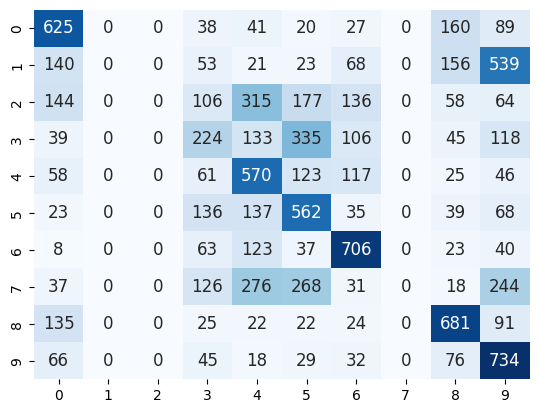

In [14]:
report_on_class(model1,test_dataloader)

## Cross Entropy

In [31]:
#CrossEntropy
model2 = ConvNet()
model2.to(device)
optimizer2 = optim.SGD(model2.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=STEP, gamma=GAMMA)
trl2,tra2,tel2,tea2,time2=test(model2,optimizer2,scheduler2,2)

Epoch: 1/40 Train Loss: 1.9210 Acc: 0.2779
Begin test......
Test Loss: 1.7790 Acc: 0.3274
Epoch: 2/40 Train Loss: 1.7811 Acc: 0.3326
Begin test......
Test Loss: 1.7075 Acc: 0.3690
Epoch: 3/40 Train Loss: 1.7654 Acc: 0.3416
Begin test......
Test Loss: 1.7175 Acc: 0.3549
Epoch: 4/40 Train Loss: 1.7618 Acc: 0.3414
Begin test......
Test Loss: 1.7640 Acc: 0.3436
Epoch: 5/40 Train Loss: 1.7457 Acc: 0.3499
Begin test......
Test Loss: 1.6477 Acc: 0.3828
Epoch: 6/40 Train Loss: 1.6464 Acc: 0.3865
Begin test......
Test Loss: 1.6213 Acc: 0.4109
Epoch: 7/40 Train Loss: 1.6297 Acc: 0.3979
Begin test......
Test Loss: 1.6105 Acc: 0.4072
Epoch: 8/40 Train Loss: 1.6191 Acc: 0.3999
Begin test......
Test Loss: 1.5338 Acc: 0.4312
Epoch: 9/40 Train Loss: 1.6057 Acc: 0.4061
Begin test......
Test Loss: 1.5062 Acc: 0.4452
Epoch: 10/40 Train Loss: 1.5871 Acc: 0.4156
Begin test......
Test Loss: 1.5156 Acc: 0.4502
Epoch: 11/40 Train Loss: 1.5192 Acc: 0.4423
Begin test......
Test Loss: 1.4376 Acc: 0.4910
Epoch: 1

classification_report
              precision    recall  f1-score   support

           0       0.65      0.60      0.63      1000
           1       0.65      0.69      0.67      1000
           2       0.49      0.42      0.45      1000
           3       0.44      0.33      0.38      1000
           4       0.52      0.49      0.50      1000
           5       0.49      0.52      0.51      1000
           6       0.56      0.79      0.66      1000
           7       0.63      0.63      0.63      1000
           8       0.66      0.71      0.69      1000
           9       0.65      0.62      0.64      1000

    accuracy                           0.58     10000
   macro avg       0.58      0.58      0.58     10000
weighted avg       0.58      0.58      0.58     10000

confusion matrix


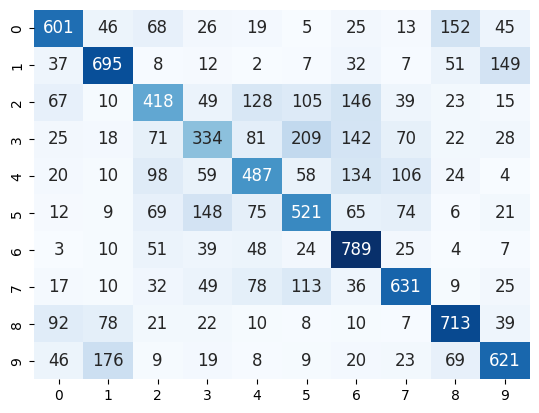

In [32]:
report_on_class(model2,test_dataloader)

## Focal Loss gamma=0.5

In [17]:
#Focal Loss gamma=0.5
model3 = ConvNet()
model3.to(device)
optimizer3 = optim.SGD(model3.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler3 = torch.optim.lr_scheduler.StepLR(optimizer3, step_size=STEP, gamma=GAMMA)
trl3,tra3,tel3,tea3,time3=test(model3,optimizer3,scheduler3,3)

Epoch: 1/40 Train Loss: 1.8484 Acc: 0.2547
Begin test......
Test Loss: 1.6686 Acc: 0.3297
Epoch: 2/40 Train Loss: 1.7111 Acc: 0.3093
Begin test......
Test Loss: 1.6393 Acc: 0.3373
Epoch: 3/40 Train Loss: 1.6637 Acc: 0.3281
Begin test......
Test Loss: 1.7477 Acc: 0.3086
Epoch: 4/40 Train Loss: 1.6747 Acc: 0.3267
Begin test......
Test Loss: 1.6063 Acc: 0.3583
Epoch: 5/40 Train Loss: 1.6548 Acc: 0.3359
Begin test......
Test Loss: 1.6485 Acc: 0.3466
Epoch: 6/40 Train Loss: 1.5168 Acc: 0.3846
Begin test......
Test Loss: 1.4297 Acc: 0.4258
Epoch: 7/40 Train Loss: 1.4699 Acc: 0.4022
Begin test......
Test Loss: 1.4112 Acc: 0.4272
Epoch: 8/40 Train Loss: 1.4403 Acc: 0.4148
Begin test......
Test Loss: 1.3739 Acc: 0.4469
Epoch: 9/40 Train Loss: 1.4244 Acc: 0.4199
Begin test......
Test Loss: 1.3293 Acc: 0.4582
Epoch: 10/40 Train Loss: 1.4121 Acc: 0.4232
Begin test......
Test Loss: 1.3056 Acc: 0.4733
Epoch: 11/40 Train Loss: 1.3182 Acc: 0.4575
Begin test......
Test Loss: 1.2076 Acc: 0.5095
Epoch: 1

classification_report
              precision    recall  f1-score   support

           0       0.59      0.57      0.58      1000
           1       0.68      0.69      0.68      1000
           2       0.46      0.38      0.42      1000
           3       0.38      0.34      0.36      1000
           4       0.49      0.47      0.48      1000
           5       0.46      0.49      0.47      1000
           6       0.63      0.71      0.67      1000
           7       0.63      0.60      0.61      1000
           8       0.65      0.66      0.65      1000
           9       0.59      0.69      0.64      1000

    accuracy                           0.56     10000
   macro avg       0.56      0.56      0.56     10000
weighted avg       0.56      0.56      0.56     10000

confusion matrix


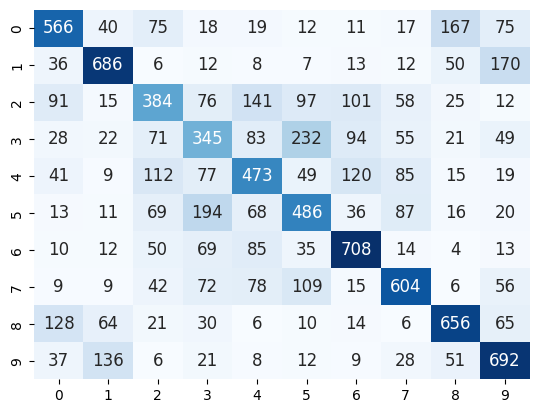

In [18]:
report_on_class(model3,test_dataloader)

## Focal Loss gamma=2

In [30]:
#Focal Loss gamma=2
model4 = ConvNet()
model4.to(device)
optimizer4 = optim.SGD(model4.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler4 = torch.optim.lr_scheduler.StepLR(optimizer4, step_size=STEP, gamma=GAMMA)
trl4,tra4,tel4,tea4,time4=test(model4,optimizer4,scheduler4,4)

Epoch: 1/40 Train Loss: 1.4808 Acc: 0.2482
Begin test......
Test Loss: 1.3004 Acc: 0.3174
Epoch: 2/40 Train Loss: 1.3116 Acc: 0.3040
Begin test......
Test Loss: 1.2347 Acc: 0.3249
Epoch: 3/40 Train Loss: 1.2769 Acc: 0.3181
Begin test......
Test Loss: 1.1852 Acc: 0.3492
Epoch: 4/40 Train Loss: 1.2707 Acc: 0.3152
Begin test......
Test Loss: 1.1374 Acc: 0.3665
Epoch: 5/40 Train Loss: 1.2681 Acc: 0.3215
Begin test......
Test Loss: 1.2066 Acc: 0.3407
Epoch: 6/40 Train Loss: 1.1802 Acc: 0.3460
Begin test......
Test Loss: 1.0757 Acc: 0.3851
Epoch: 7/40 Train Loss: 1.1496 Acc: 0.3587
Begin test......
Test Loss: 1.0591 Acc: 0.3990
Epoch: 8/40 Train Loss: 1.1521 Acc: 0.3589
Begin test......
Test Loss: 1.0383 Acc: 0.4020
Epoch: 9/40 Train Loss: 1.1344 Acc: 0.3682
Begin test......
Test Loss: 1.0306 Acc: 0.4104
Epoch: 10/40 Train Loss: 1.1313 Acc: 0.3705
Begin test......
Test Loss: 1.0060 Acc: 0.4048
Epoch: 11/40 Train Loss: 1.0546 Acc: 0.3940
Begin test......
Test Loss: 0.9549 Acc: 0.4301
Epoch: 1

classification_report
              precision    recall  f1-score   support

           0       0.58      0.47      0.52      1000
           1       0.57      0.71      0.63      1000
           2       0.40      0.40      0.40      1000
           3       0.38      0.31      0.34      1000
           4       0.44      0.35      0.39      1000
           5       0.46      0.37      0.41      1000
           6       0.57      0.66      0.61      1000
           7       0.51      0.55      0.53      1000
           8       0.60      0.66      0.63      1000
           9       0.54      0.64      0.59      1000

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.51     10000
weighted avg       0.51      0.51      0.51     10000

confusion matrix


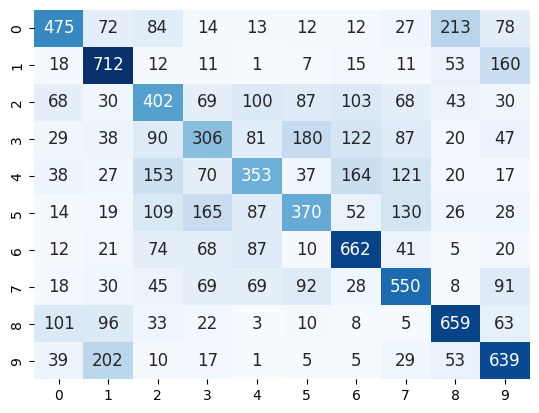

In [29]:
report_on_class(model4,test_dataloader)

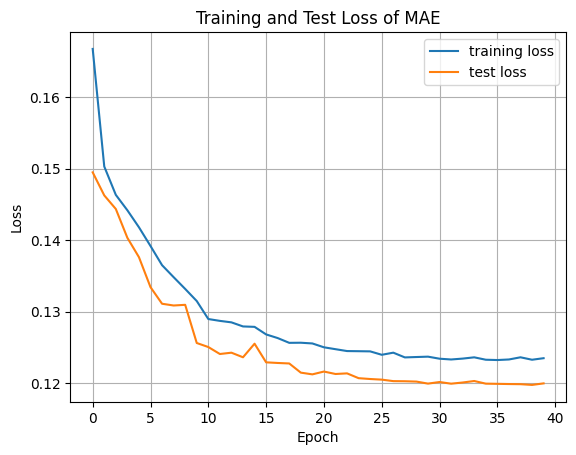

In [21]:
plt.plot(trl1,label="training loss")
plt.plot(tel1,label="test loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss of MAE')
plt.grid(True)
plt.legend()
plt.show()

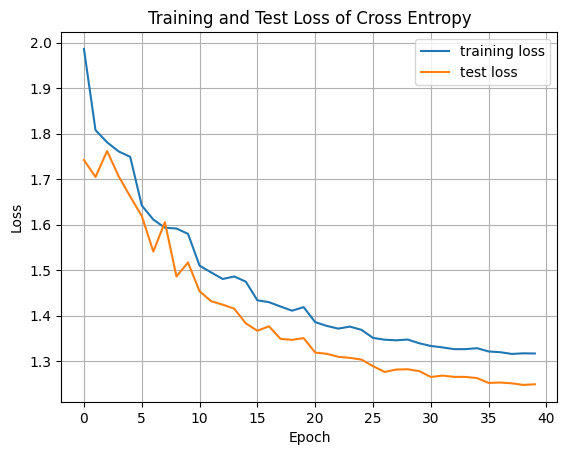

In [22]:
plt.plot(trl2,label="training loss")
plt.plot(tel2,label="test loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss of Cross Entropy')
plt.grid(True)
plt.legend()
plt.show()

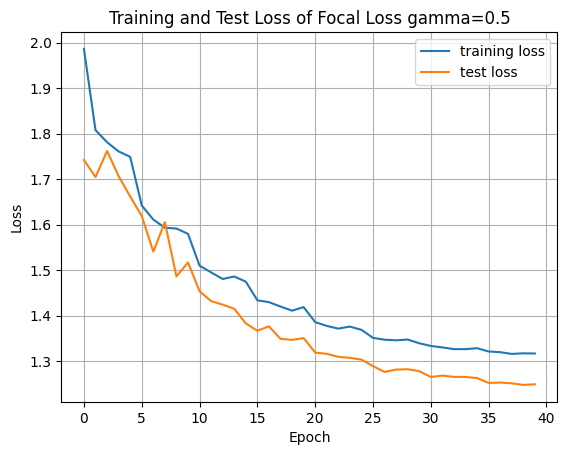

In [23]:
plt.plot(trl2,label="training loss")
plt.plot(tel2,label="test loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss of Focal Loss gamma=0.5')
plt.grid(True)
plt.legend()
plt.show()

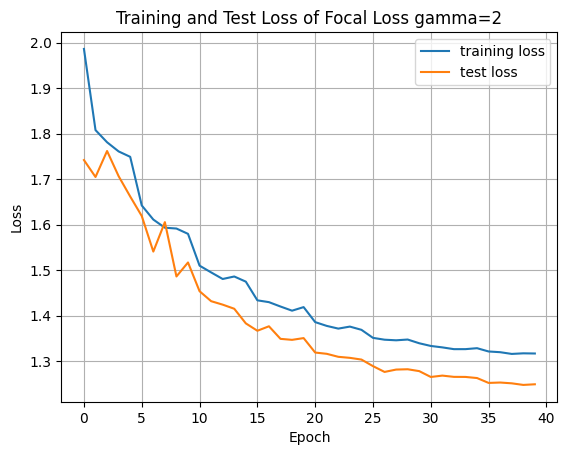

In [24]:
plt.plot(trl2,label="training loss")
plt.plot(tel2,label="test loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss of Focal Loss gamma=2')
plt.grid(True)
plt.legend()
plt.show()

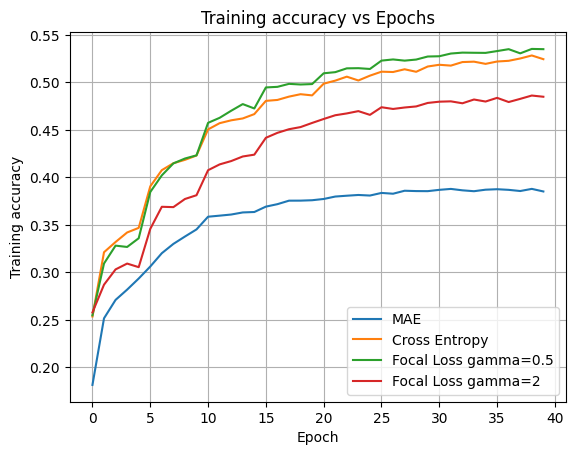

In [25]:
plt.plot(tra1, label='MAE')
plt.plot(tra2, label='Cross Entropy')
plt.plot(tra3, label='Focal Loss gamma=0.5')
plt.plot(tra4,label='Focal Loss gamma=2')

# 添加标签和标题
plt.xlabel('Epoch')
plt.ylabel('Training accuracy')
plt.title('Training accuracy vs Epochs')
plt.legend()  # 显示图例
plt.grid(True)
plt.show()

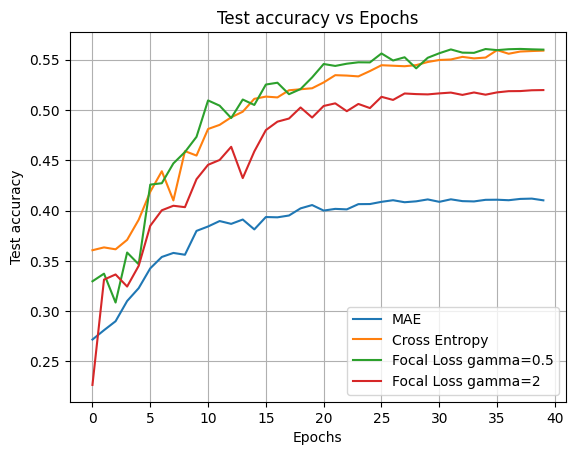

In [26]:
plt.plot(tea1, label='MAE')
plt.plot(tea2, label='Cross Entropy')
plt.plot(tea3, label='Focal Loss gamma=0.5')
plt.plot(tea4,label='Focal Loss gamma=2')

# 添加标签和标题
plt.xlabel('Epochs')
plt.ylabel('Test accuracy')
plt.title('Test accuracy vs Epochs')
plt.legend()  # 显示图例
plt.grid(True)
plt.show()

In [27]:
data = {'Loss function': ['MAE', 'Cross Entropy', 'Focal Loss gamma=0.5','Focal Loss gamma=2'], 'Total Time': [time1,time2,time3,time4]}
df = pd.DataFrame(data)
df

,Loss function,Total Time
0,MAE,301.739858
1,Cross Entropy,303.900803
2,Focal Loss gamma=0.5,303.817862
3,Focal Loss gamma=2,300.163424
